In [16]:
# Imports and setup
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

root = Path.cwd().parent


In [17]:
# Load datasets
shipment_decisions_df = pd.read_csv(root/'results'/'shipment_decisions.csv').groupby('Date', as_index=False)['Shipment'].sum()
inventory_decisions_df = pd.read_csv(root/'results'/'inventory_decisions.csv').groupby('Date', as_index=False)['Inventory'].sum()
shortage_decisions_df = pd.read_csv(root/'results'/'shortage_decisions.csv').groupby('Date', as_index=False)['Shortage'].sum()
holding_costs_df = pd.read_csv(root/'results'/'holding_costs.csv').groupby('Date', as_index=False)['HoldingCost'].sum()
shortage_weights_df = pd.read_csv(root/'results'/'shortage_weights.csv').groupby('Date', as_index=False)['ShortageWeight'].sum()


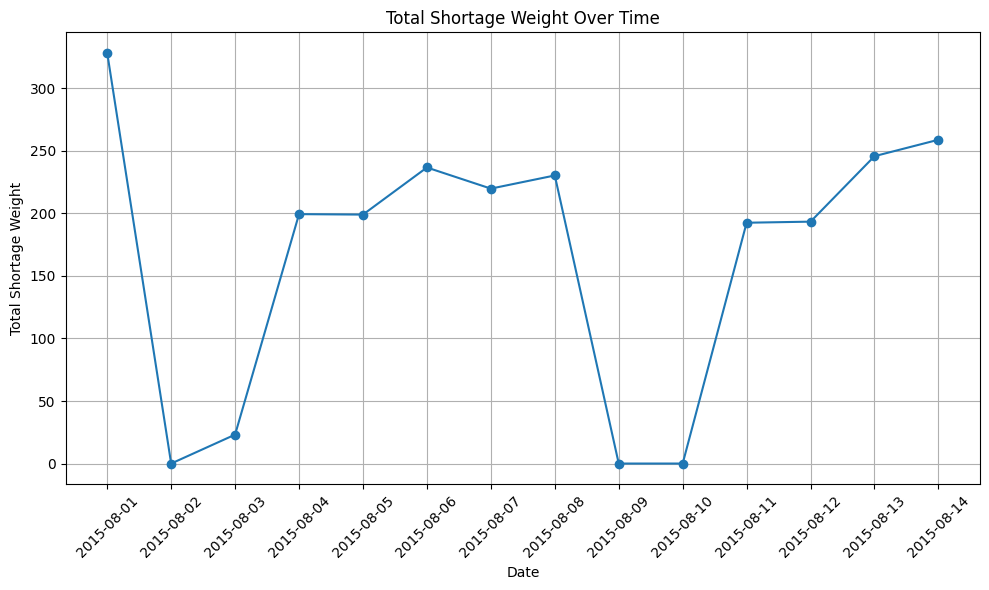

In [18]:
x_values = shortage_weights_df['Date']
y_values = shortage_weights_df['ShortageWeight']

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o')
plt.xlabel('Date')
plt.ylabel('Total Shortage Weight')
plt.title('Total Shortage Weight Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()